In [1]:
%matplotlib inline


# Two-class AdaBoost

This example fits an AdaBoosted decision stump on a non-linearly separable
classification dataset composed of two "Gaussian quantiles" clusters
(see :func:`sklearn.datasets.make_gaussian_quantiles`) and plots the decision
boundary and decision scores. The distributions of decision scores are shown
separately for samples of class A and B. The predicted class label for each
sample is determined by the sign of the decision score. Samples with decision
scores greater than zero are classified as B, and are otherwise classified
as A. The magnitude of a decision score determines the degree of likeness with
the predicted class label. Additionally, a new dataset could be constructed
containing a desired purity of class B, for example, by only selecting samples
with a decision score above some value.


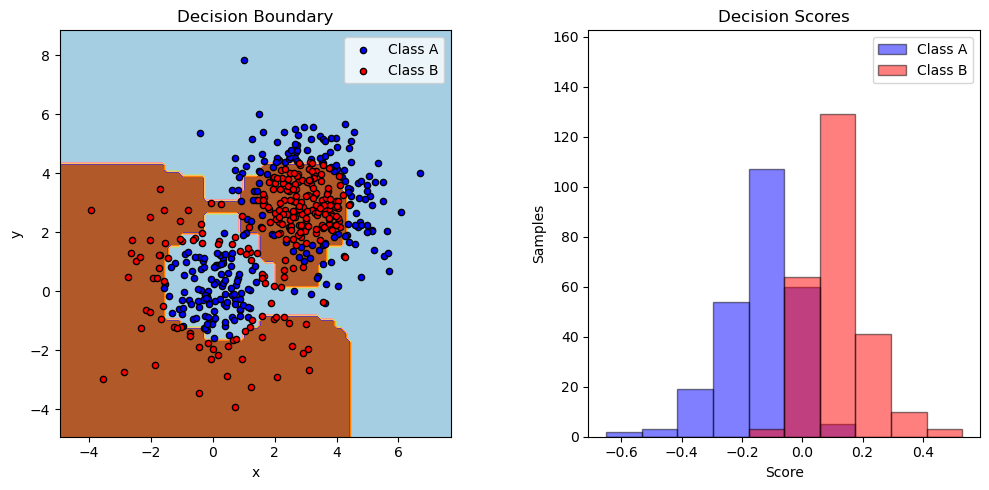

In [2]:
# Author: Noel Dawe <noel.dawe@gmail.com>
# Oriignal Source link: https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html#sphx-glr-auto-examples-ensemble-plot-adaboost-twoclass-py
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
from sklearn.inspection import DecisionBoundaryDisplay


# Construct dataset
X1, y1 = make_gaussian_quantiles(
    cov=2.0, n_samples=200, n_features=2, n_classes=2, random_state=1
)
X2, y2 = make_gaussian_quantiles(
    mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=1
)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2 + 1))

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200
)

bdt.fit(X, y)

plot_colors = "br"
plot_step = 0.02
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
ax = plt.subplot(121)
disp = DecisionBoundaryDisplay.from_estimator(
    bdt,
    X,
    cmap=plt.cm.Paired,
    response_method="predict",
    ax=ax,
    xlabel="x",
    ylabel="y",
)
x_min, x_max = disp.xx0.min(), disp.xx0.max()
y_min, y_max = disp.xx1.min(), disp.xx1.max()
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0],
        X[idx, 1],
        c=c,
        cmap=plt.cm.Paired,
        s=20,
        edgecolor="k",
        label="Class %s" % n,
    )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc="upper right")

plt.title("Decision Boundary")

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(
        twoclass_output[y == i],
        bins=10,
        range=plot_range,
        facecolor=c,
        label="Class %s" % n,
        alpha=0.5,
        edgecolor="k",
    )
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc="upper right")
plt.ylabel("Samples")
plt.xlabel("Score")
plt.title("Decision Scores")

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()